# Постановка задачи

1)Изучить теоретические основы и методы решения поставленной задачи.

2)Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.

3)Провести предобработку данных (удаление шумов, нормализация и т.д.).

4)Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.

5)Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 

6)Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое
будет выдавать прогноз, полученный в задании 4 или 5 (один или два прогноза, на выбор учащегося).

7)Оценить точность модели на тренировочном и тестовом датасете. 

8)Создать репозиторий в GitHub / GitLab и разместить там код исследования. Оформить файл README.

In [1]:
#Импортируем необходимые библиотеки 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics


%matplotlib inline

C:\Users\sumbu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sumbu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\sumbu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
x_bp = pd.read_excel('Data/X_bp.xlsx', index_col=0)
x_bp.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                             1.86           2030.00                 738.74   
1                             1.86           2030.00                 738.74   
2                             1.86           2030.00                 738.74   
3                             1.86           2030.00                 738.74   
4                             2.77           2030.00                 753.00   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                        30.00                            22.27   
1                        50.00                            23.75   
2                        49.90                            33.00   
3                       129.00                            21.25   
4                       111.86                            22.27   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                    100.00                         210.00   
1                    284.62                         210.00   
2                    284.62                         210.00   
3                    300.00                         210.00   
4                    284.62                         210.00   

   Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                 70.00                        3000.00   
1                                 70.00                        3000.00   
2                                 70.00                        3000.00   
3                                 70.00                        3000.00   
4                                 70.00                        3000.00   

   Потребление смолы, г/м2  
0                   220.00  
1                   220.00  
2                   220.00  
3                   220.00  
4                   220.00

In [65]:
x_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB


In [66]:
x_nup = pd.read_excel('Data/X_nup.xlsx', index_col=0)
x_nup.head()

Угол нашивки, град  Шаг нашивки  Плотность нашивки
0                   0         4.00              57.00
1                   0         4.00              60.00
2                   0         4.00              70.00
3                   0         5.00              47.00
4                   0         5.00              57.00

In [67]:
x_nup.shape

(1040, 3)

Сделаем объединение двух таблиц по индексу, тип объединения INNER, как указано в задаче.

In [68]:
df_row = x_bp.join(x_nup, how='inner')
df_row.shape

(1023, 13)

В датасете осталось 1023 строки

In [69]:
df = df_row.copy() #сделаем копию данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int64  
 11  Шаг нашивки      

Все признаки имеют тип float64, один int64, признаков с типом "object" нет.

In [9]:
#Проверим на пропуски значений

df.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

In [10]:
# Количество уникальных значений в каждом столбце

df.nunique()

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

In [11]:
# Посмотрим описательную статистику

df.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                     2466.922843               218.423144   
std                       485.628006                59.735931   
min                      1036.856605                33.803026   
25%                      2135.850448               179.627520   
50%                      2459.524526               219.198882   
75%                      2767.193119               257.481724   
max                      3848.436732               414.590628   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean            44.252199     6.899222          57.153929  
std             45.015793     2.563467          12.350969  
min              0.000000     0.000000           0.000000  
25%              0.000000     5.080033          49.799212  
50%              0.000000     6.916144          57.341920  
75%             90.000000     8.586293          64.944961  
max             90.000000    14.440522         103.988901

In [12]:
#По заданию выводим среднее значение

df.mean()

Соотношение матрица-наполнитель            2.930366
Плотность, кг/м3                        1975.734888
модуль упругости, ГПа                    739.923233
Количество отвердителя, м.%              110.570769
Содержание эпоксидных групп,%_2           22.244390
Температура вспышки, С_2                 285.882151
Поверхностная плотность, г/м2            482.731833
Модуль упругости при растяжении, ГПа      73.328571
Прочность при растяжении, МПа           2466.922843
Потребление смолы, г/м2                  218.423144
Угол нашивки, град                        44.252199
Шаг нашивки                                6.899222
Плотность нашивки                         57.153929
dtype: float64

In [13]:
#Медиана

df.median()

Соотношение матрица-наполнитель            2.906878
Плотность, кг/м3                        1977.621657
модуль упругости, ГПа                    739.664328
Количество отвердителя, м.%              110.564840
Содержание эпоксидных групп,%_2           22.230744
Температура вспышки, С_2                 285.896812
Поверхностная плотность, г/м2            451.864365
Модуль упругости при растяжении, ГПа      73.268805
Прочность при растяжении, МПа           2459.524526
Потребление смолы, г/м2                  219.198882
Угол нашивки, град                         0.000000
Шаг нашивки                                6.916144
Плотность нашивки                         57.341920
dtype: float64

## Построим графики распределения и графики типа boxplot("ящики с усами")

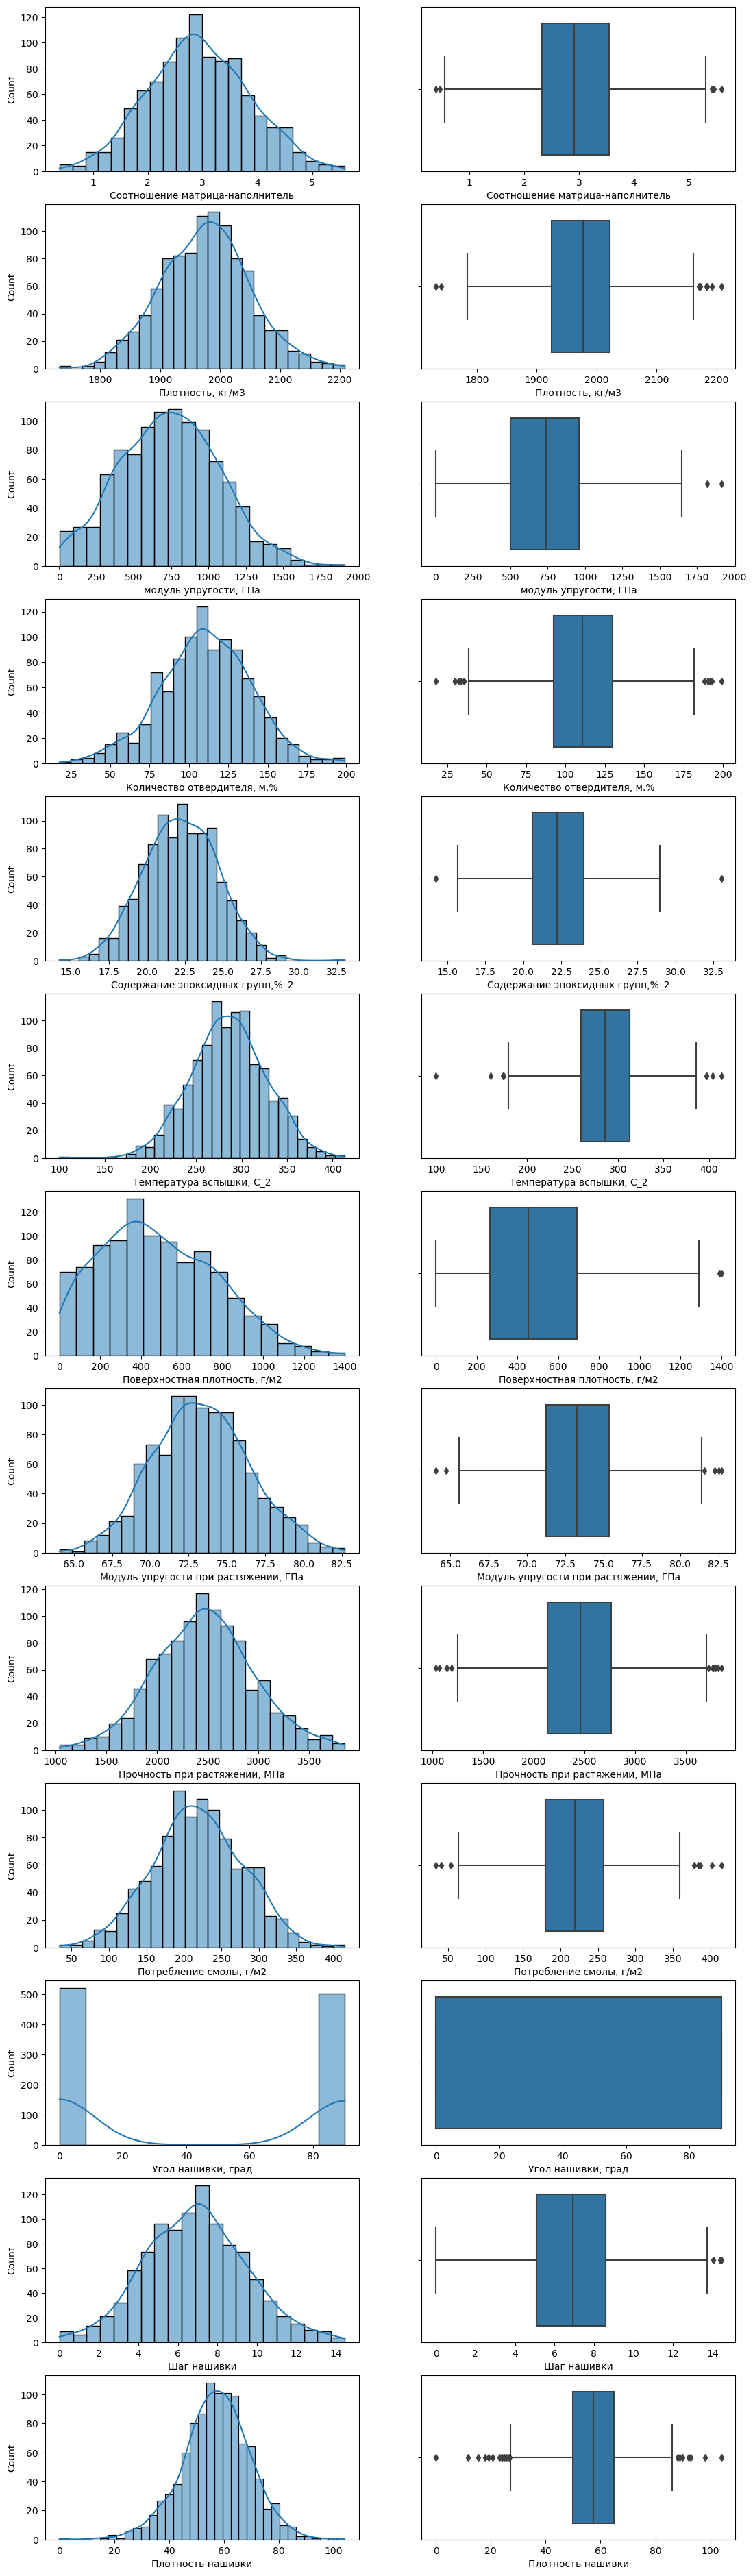

In [14]:
fig, axes = plt.subplots(13, 2, figsize=(13, 48))
for k, column in enumerate(df.columns):    
    sns.histplot(data=df, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=df, x=column, ax=axes[k, 1])
plt.show()

Кроме "Угол нашивки, град" все признаки имеют нормальное распределение. Признаки количественные, вещественные, не имеют отрицательных значений.

"Угол нашивки, град" имеет два значения, можно преобразовать его к бинарному значению.

## Построим попарные графики рассеяния точек

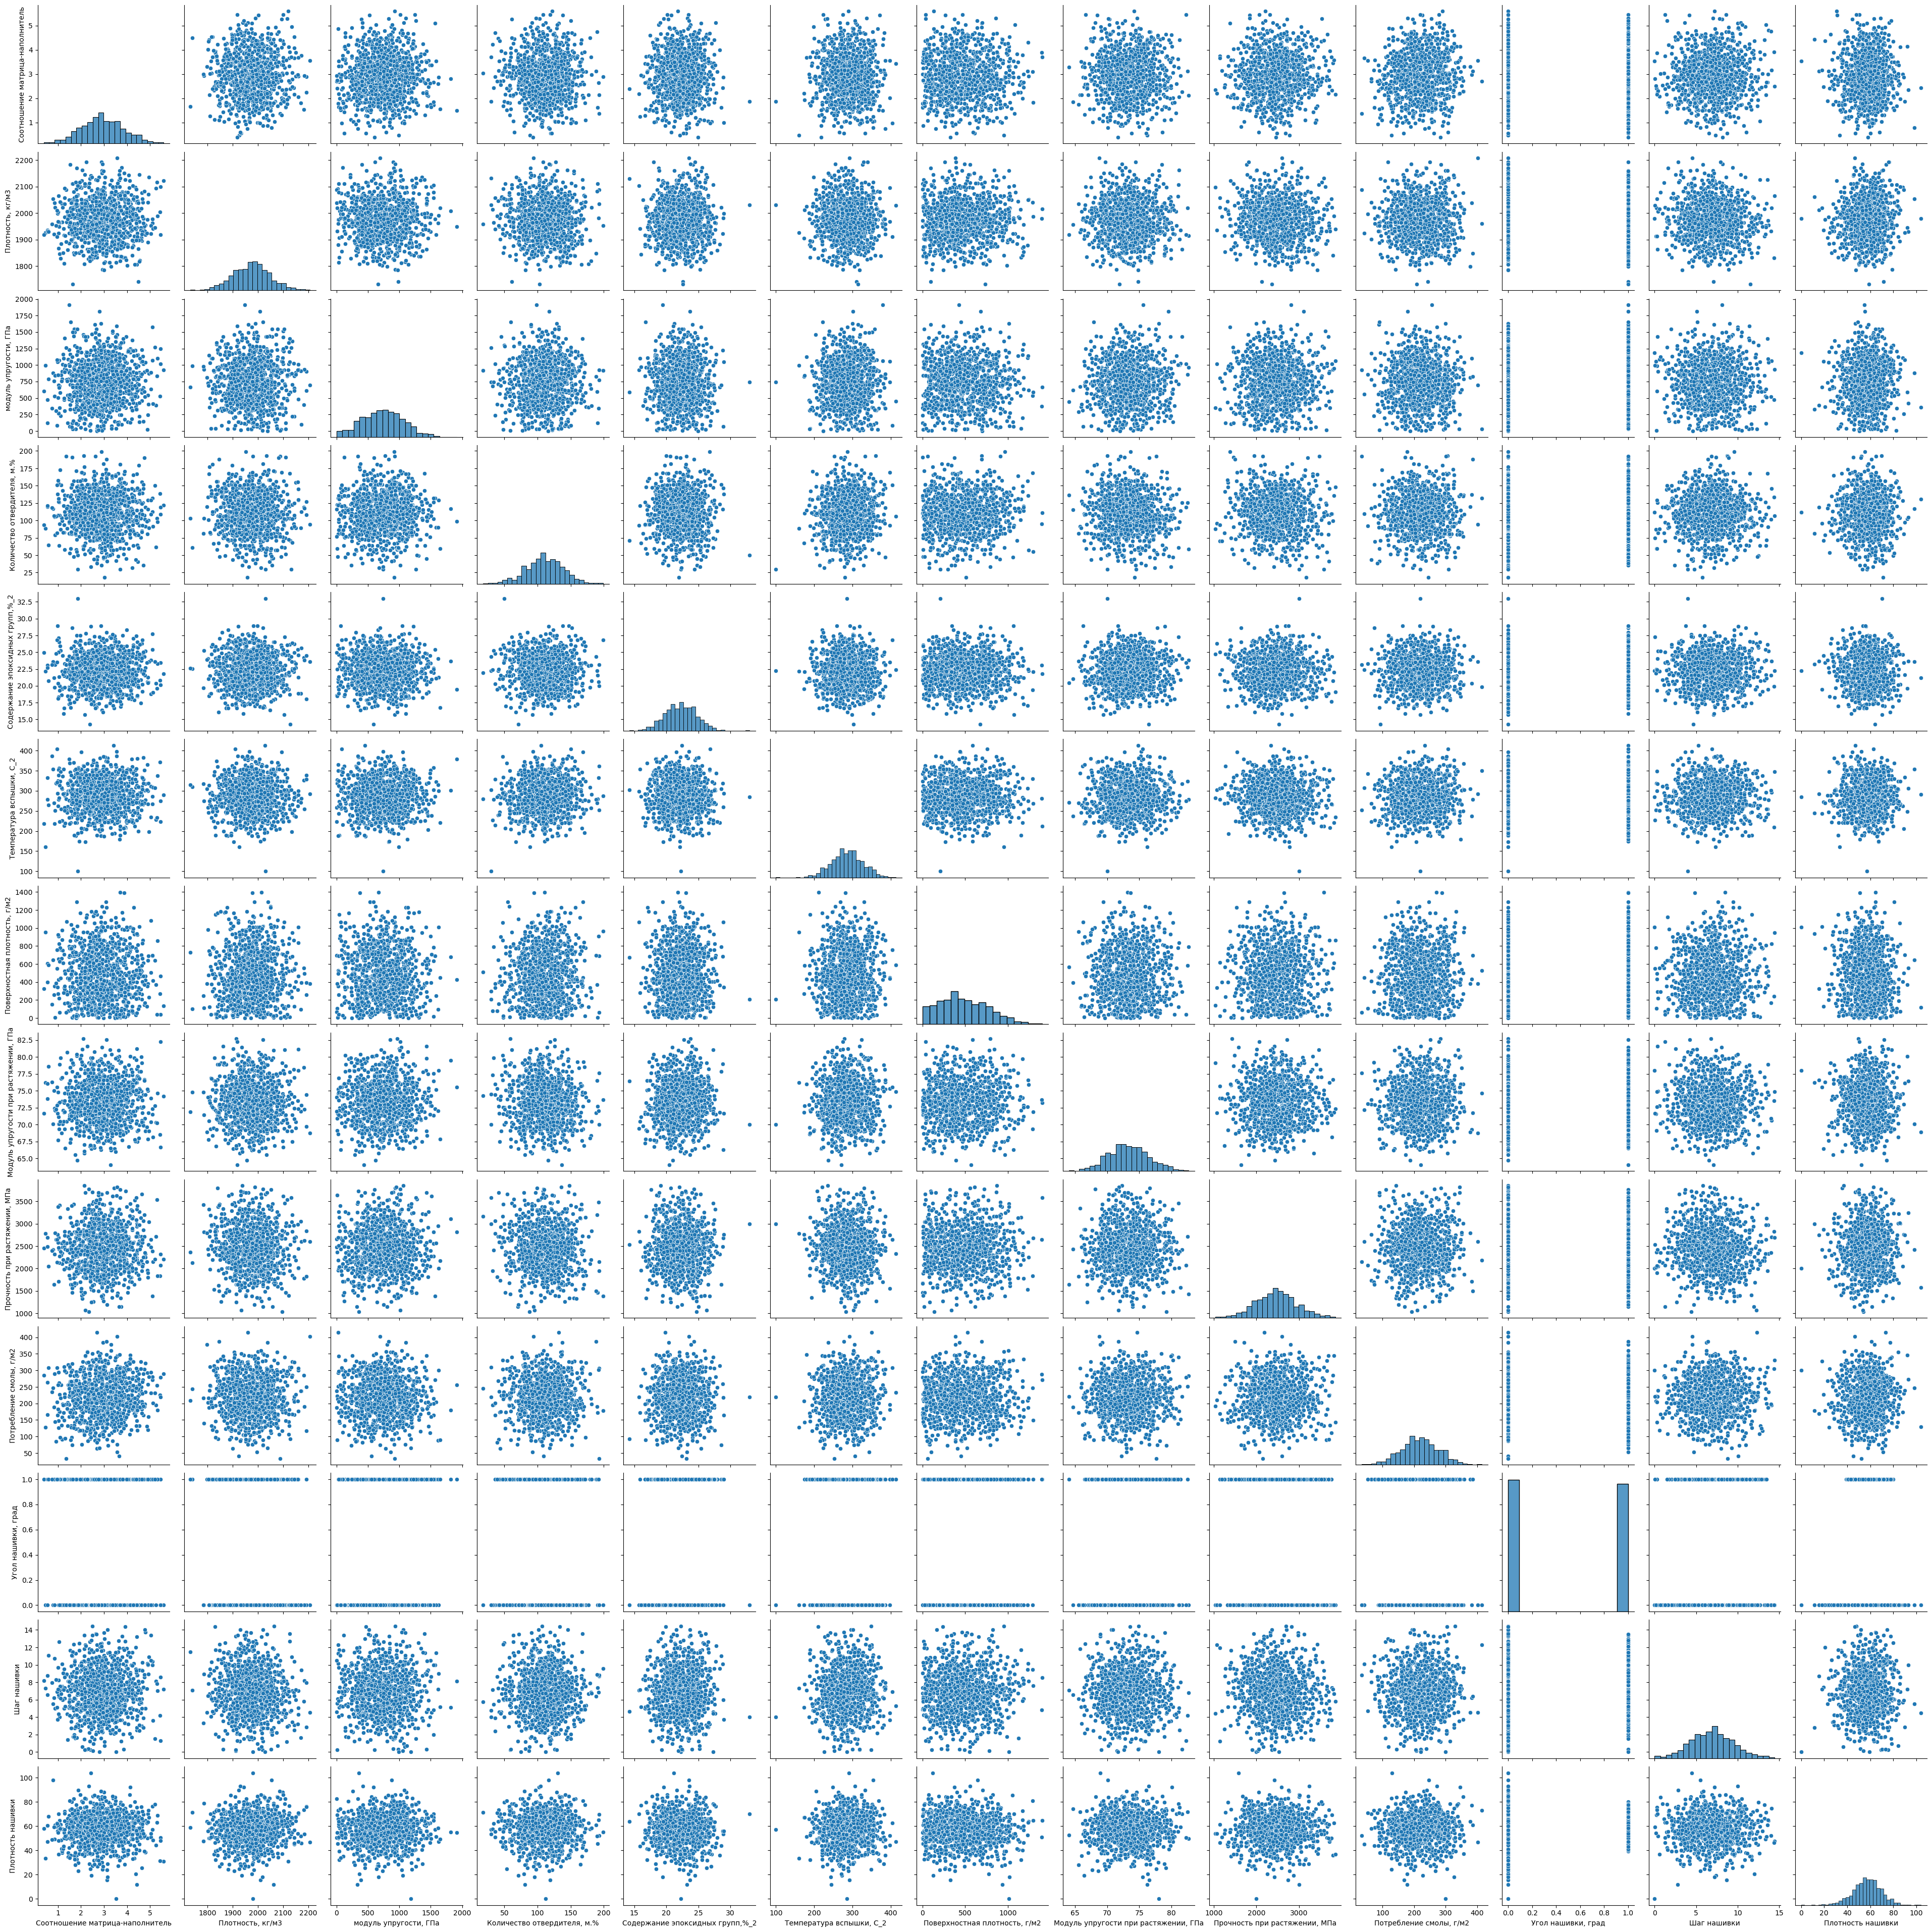

In [17]:
sns.pairplot(df, height=3)

Приведенные выше графики свидетельствуют об отсутствии линейной зависимости между характеристиками. По ним видны выбросы, как и на графиках выше(боксплотах)

In [70]:
#Посчитаем кол-во выбросов, методом 3х сигм и методом межквартильных расстояний

count_3s = 0
count_iq = 0

for column in df:
    d = df.loc[:, [column]]
    # методом 3-х сигм
    zscore = (df[column] - df[column].mean()) / df[column].std()
    d['3s'] = zscore.abs() > 3
    count_3s += d['3s'].sum()
    # методом межквартильных расстояний
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (df[column] <= lower) | (df[column] >= upper)
    count_iq += d['iq'].sum()

print('\nМетод 3-х сигм. Всего выбросов:', count_3s)
print('Метод межквартильных расстояний. Всего выбросов:', count_iq)


Метод 3-х сигм. Всего выбросов: 24
Метод межквартильных расстояний. Всего выбросов: 93



Датасет уже был подготовлен и очищен от явного шума, применим метод 3-х сигм, чтобы потерять меньше значимой информации.

In [71]:
# Удалить выбросы методом 3-х сигм

outliers = pd.DataFrame(index=df.index)
for column in df:
    zscore = (df[column] - df[column].mean()) / df[column].std()
    outliers[column] = (zscore.abs() > 3)
df = df[outliers.sum(axis=1)==0]
df.shape

(1000, 13)

In [72]:
#Сохраним Df в отдельный файл

df.to_excel('composites.xlsx')

"Угол нашивки, град" имеет два значения, можно преобразовать его к бинарному значению.

In [73]:
df = df.replace({'Угол нашивки, град': {0.0 : 0, 90.0 : 1}})
df['Угол нашивки, град'] = df['Угол нашивки, град'].astype(int)
df['Угол нашивки, град'].value_counts()

0    504
1    496
Name: Угол нашивки, град, dtype: int64

## Построим матрицу корреляции, для поиска зависимостей

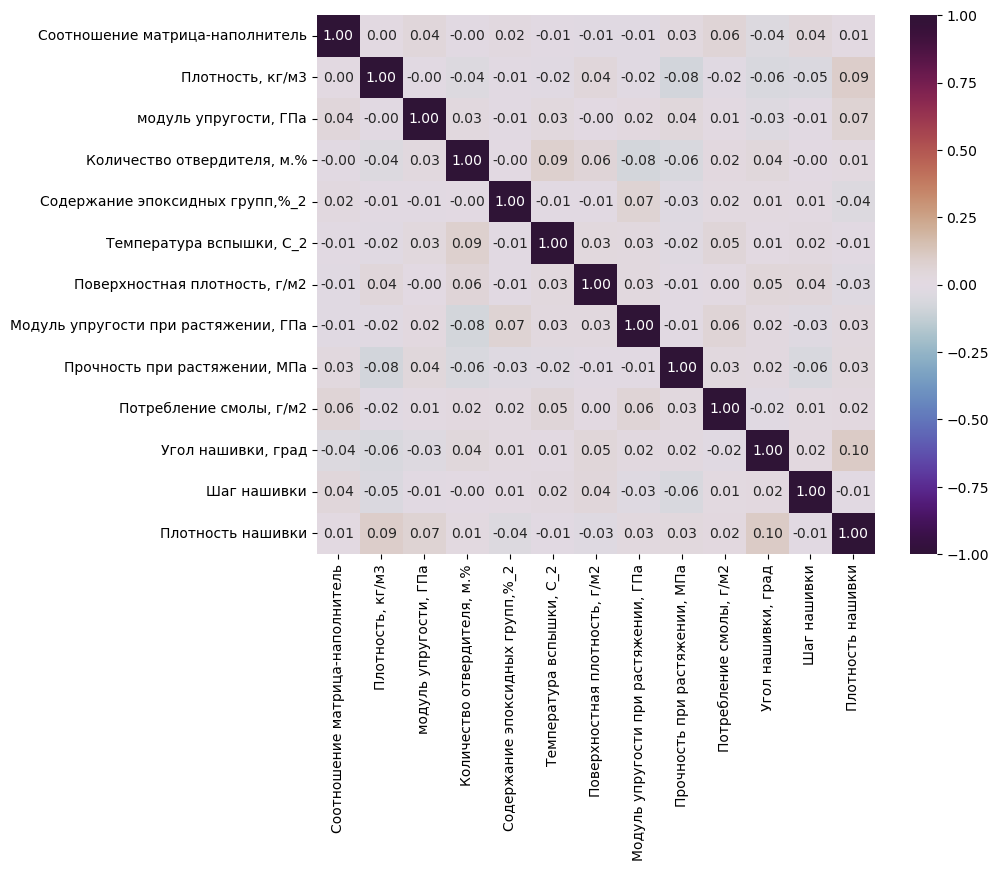

In [74]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='twilight_shifted', ax=ax)
plt.show()

Коэффициенты корреляции близки к 0, что показывают отсутствие линейной зависимости между признаками. 

### Напишем вспомогательную функцию для запуска моделей, кросс-валидации и получения метрик.

In [21]:
def run_models(models, x, y):
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=42)
    scoring = ['r2', 
                'max_error', 
                'neg_root_mean_squared_error', 
                'neg_mean_absolute_error',]
    for model_name, model in models.items():
        scores = cross_validate(model, x, y, cv=cv, scoring=scoring)
        stat.loc[model_name, 'R2'] = scores['test_r2'].mean()
        stat.loc[model_name, 'RMSE'] = scores['test_neg_root_mean_squared_error'].mean()
        stat.loc[model_name, 'MAE'] = scores['test_neg_mean_absolute_error'].mean()
        stat.loc[model_name, 'max_error'] = scores['test_max_error'].mean()
    return stat

### Для поиска параметров по сетке так же напишем вспомогательную функцию.

In [22]:
def run_grid_search(model, params, x, y):
    pd.options.display.max_colwidth = 200
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=42)
    
    scoring = 'neg_mean_absolute_error'
    searcher = GridSearchCV(model, params, cv=cv, scoring=scoring)
    searcher.fit(x, y)
    stat.loc[:, 'params'] = searcher.cv_results_['params']
    stat.loc[:, 'MAE'] = searcher.cv_results_['mean_test_score']
    stat.loc[:, 'rank'] = searcher.cv_results_['rank_test_score']
    return stat, searcher.best_estimator_

#### Функция для метрик

In [23]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred, squared=False) * -1
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred) * -1
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred) * -1
    return stat

## Часть 1. Модели для прогноза модуля упругости при растяжении, ГПа

In [24]:
X_upr = df.copy()
y_upr = X_upr.pop('Модуль упругости при растяжении, ГПа')
X_upr.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
1                         1.857143            2030.0             738.736842   
3                         1.857143            2030.0             738.736842   
4                         2.771331            2030.0             753.000000   
5                         2.767918            2000.0             748.000000   
6                         2.569620            1910.0             807.000000   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
1                        50.00                        23.750000   
3                       129.00                        21.250000   
4                       111.86                        22.267857   
5                       111.86                        22.267857   
6                       111.86                        22.267857   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
1                284.615385                          210.0   
3                300.000000                          210.0   
4                284.615385                          210.0   
5                284.615385                          210.0   
6                284.615385                          210.0   

   Прочность при растяжении, МПа  Потребление смолы, г/м2  Угол нашивки, град  \
1                         3000.0                    220.0                   0   
3                         3000.0                    220.0                   0   
4                         3000.0                    220.0                   0   
5                         3000.0                    220.0                   0   
6                         3000.0                    220.0                   0   

   Шаг нашивки  Плотность нашивки  
1          4.0               60.0  
3          5.0               47.0  
4          5.0               57.0  
5          5.0               60.0  
6          5.0               70.0

In [25]:
#Разделим данные на обучающую и тестовую выборку

X_train_upr, X_test_upr, y_train_upr, y_test_upr = train_test_split(X_upr, y_upr, test_size=0.3, random_state=42)

In [26]:
#Проверим разделение

print(X_train_upr.shape)
print(X_test_upr.shape)

(700, 12)
(300, 12)


In [27]:
#pip install lazypredict

Используя библиотеку lazy predict попробуем подобрать лучшую модель

In [28]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0,
                    ignore_warnings=False,
                    custom_metric=None)
models, predictions = reg.fit(X_train_upr, X_test_upr, y_train_upr, y_test_upr)
models

100%|██████████| 42/42 [00:12<00:00,  3.37it/s]


Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
QuantileRegressor                           -0.05      -0.01  3.08        6.95
Lasso                                       -0.05      -0.01  3.08        0.01
DummyRegressor                              -0.05      -0.01  3.08        0.02
ElasticNet                                  -0.05      -0.01  3.08        0.03
LassoLars                                   -0.05      -0.01  3.08        0.02
BayesianRidge                               -0.06      -0.01  3.09        0.08
GammaRegressor                              -0.06      -0.01  3.09        0.02
TweedieRegressor                            -0.06      -0.01  3.09        0.03
LassoLarsIC                                 -0.06      -0.02  3.10        0.05
OrthogonalMatchingPursuit                   -0.06      -0.02  3.10        0.01
OrthogonalMatchingPursuitCV                 -0.06      -0.02  3.10        0.02
ElasticNetCV                                -0.07      -0.03  3.11        0.13
LassoLarsCV                                 -0.07      -0.03  3.11        0.06
LarsCV                                      -0.07      -0.03  3.11        0.05
LassoCV                                     -0.07      -0.03  3.11        0.09
RidgeCV                                     -0.08      -0.04  3.13        0.02
PoissonRegressor                            -0.08      -0.04  3.13        0.02
Ridge                                       -0.08      -0.04  3.13        0.02
TransformedTargetRegressor                  -0.08      -0.04  3.13        0.02
LinearRegression                            -0.08      -0.04  3.13        0.03
Lars                                        -0.08      -0.04  3.13        0.03
SGDRegressor                                -0.08      -0.04  3.13        0.02
AdaBoostRegressor                           -0.09      -0.05  3.14        0.21
NuSVR                                       -0.10      -0.05  3.15        0.11
HuberRegressor                              -0.10      -0.05  3.15        0.03
LinearSVR                                   -0.12      -0.08  3.19        0.02
ExtraTreesRegressor                         -0.13      -0.09  3.20        0.44
SVR                                         -0.15      -0.10  3.22        0.12
RandomForestRegressor                       -0.15      -0.11  3.23        0.80
GradientBoostingRegressor                   -0.20      -0.15  3.29        0.33
KNeighborsRegressor                         -0.23      -0.18  3.34        0.04
BaggingRegressor                            -0.26      -0.21  3.38        0.11
XGBRegressor                                -0.34      -0.29  3.48        0.24
LGBMRegressor                               -0.34      -0.29  3.49        0.17
HistGradientBoostingRegressor               -0.36      -0.31  3.51        0.70
PassiveAggressiveRegressor                  -0.94      -0.86  4.19        0.02
RANSACRegressor                             -1.10      -1.01  4.36        0.12
DecisionTreeRegressor                       -1.26      -1.17  4.52        0.02
ExtraTreeRegressor                          -1.53      -1.43  4.79        0.03
MLPRegressor                               -11.40     -10.91 10.60        1.05
GaussianProcessRegressor                  -278.18    -266.98 50.27        0.10
KernelRidge                               -589.82    -566.10 73.13        0.04

Все модели в топ-10 показывают примерно одинаковые значения, что и базовая модель Dummy Regressor

### Нормализуем значения

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_upr_norm = scaler.fit_transform(X_train_upr)
X_test_upr_norm = scaler.transform(X_test_upr)
X_train_upr_norm

array([[0.6880626 , 0.04276343, 0.44112821, ..., 1.        , 0.45711284,
        0.48622653],
       [0.27254128, 0.51555513, 0.51399785, ..., 0.        , 0.88703244,
        0.33014733],
       [0.489449  , 0.72212625, 0.67984038, ..., 0.        , 0.04948856,
        0.87639155],
       ...,
       [0.58696556, 0.42473537, 0.81961226, ..., 1.        , 0.45103716,
        0.61257161],
       [0.37439017, 0.43965487, 0.44845758, ..., 0.        , 0.38854483,
        0.57484482],
       [0.90465353, 0.43334053, 0.65070323, ..., 0.        , 0.73826198,
        0.76801487]])

In [30]:
# Сравнение моделей с параметрами по умолчанию
def_models1 = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42)
}

stat_1 = run_models(def_models1, X_train_upr_norm, y_train_upr)
stat_1.style.highlight_max(color='green', axis=0)

Коэффициент детерминации R2 близок к 0 для линейных моделей и метода опорных векторов. Значит, они не лучше базовой модели. И остальные метрики у них примерно совпадают с базовой моделью.

Гораздо хуже линейных с гиперпараметрами по умолчанию отработали метод ближайших соседей и деревья решений.

Случайный лес отработал лучше, чем одно дерево решений, но хуже, чем линейные модели.

#### Попробуем улучшить модели с помощью подбора гиперпараметров методом GridSearch

In [31]:
s_models1 = {}

##### Ridge

alpha, default=1.0

Regularization strength; must be a positive float

solver {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’}, default=’auto’

Solver to use in the computational routines

random_state - только для ‘sag’, ‘saga’
positive - только для ‘lbfgs’

In [32]:
params1 = [
  {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': range(1, 100, 1)
  },           
  {
    'solver': ['lbfgs'],
    'alpha': range(1, 100, 1),
    'positive': [True]
  }
]
search, smodel = run_grid_search(Ridge(), params1, X_train_upr_norm, y_train_upr)
s_models1[str(smodel)] = smodel
search[search['rank']<3]

params   MAE  rank
497  {'alpha': 3, 'positive': True, 'solver': 'lbfgs'} -2.49     2
498  {'alpha': 4, 'positive': True, 'solver': 'lbfgs'} -2.49     1

##### Lasso

alpha, default=1.0
Constant that multiplies the L1 term

In [33]:
params1 = [
  {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.095, 0.1, 0.150, 0.2, 0.5, 1]
  }
]
search, smodel = run_grid_search(Lasso(), params1, X_train_upr_norm, y_train_upr)
s_models1[str(smodel)] = smodel
search[search['rank']<3]

params   MAE  rank
0  {'alpha': 0.001} -2.50     2
2   {'alpha': 0.01} -2.50     1

##### SVR

kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}

Остальные параметры подходят для разных ядер

C, default=1.0
Regularization parameter

In [34]:
params1 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['rbf'],
      'C': [0.01, 0.02, 0.03, 0.04]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.01, 0.02, 0.03, 0.04, 0.5]
    }
]
search, smodel = run_grid_search(SVR(), params1, X_train_upr_norm, y_train_upr)
s_models1[str(smodel)] = smodel
search[search['rank']<3]

params   MAE  rank
7  {'C': 0.01, 'kernel': 'poly'} -2.48     2
8  {'C': 0.02, 'kernel': 'poly'} -2.48     1

##### KNeighborsRegressor

n_neighbors, default=5

In [35]:
params1 = {
    'n_neighbors': range(3, 31, 2)
}
search, smodel = run_grid_search(KNeighborsRegressor(), params1, X_train_upr_norm, y_train_upr)
s_models1[str(smodel)] = smodel
search[search['rank']<3]

params   MAE  rank
11  {'n_neighbors': 25} -2.56     2
12  {'n_neighbors': 27} -2.55     1

##### DecisionTreeRegressor

criterion {“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}
The function to measure the quality of a split.

splitter{“best”, “random”}

max_depth
The maximum depth of the tree

max_features
The number of features to consider when looking for the best split

In [36]:
params1 = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3],
    'max_features': range(1, 11, 1)
}
search, smodel = run_grid_search(DecisionTreeRegressor(), params1, X_train_upr_norm, y_train_upr)
s_models1[str(smodel)] = smodel
search[search['rank']<3]

params  \
29    {'criterion': 'squared_error', 'max_depth': 2, 'max_features': 5, 'splitter': 'random'}   
127  {'criterion': 'absolute_error', 'max_depth': 1, 'max_features': 4, 'splitter': 'random'}   

      MAE  rank  
29  -2.50     2  
127 -2.49     1

##### RandomForestRegressor

n_estimators
The number of trees in the forest.

criterion {“squared_error”, “absolute_error”, “poisson”}
The function to measure the quality of a split

max_depth
The maximum depth of the tree

max_features
The number of features to consider when looking for the best split

bootstrap
Whether bootstrap samples are used when building trees

In [37]:
params1 = {
    'n_estimators': [50, 100], 
    'criterion': ['absolute_error'],
    'max_depth': [2, 3, 4, 5],
    'max_features': [1, 2, 11],
    'bootstrap': [False]
}
search, smodel = run_grid_search(RandomForestRegressor(), params1, X_train_upr_norm, y_train_upr)
s_models1[str(smodel)] = smodel
search[search['rank']<3]

params  \
6  {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 1, 'n_estimators': 50}   
8  {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 2, 'n_estimators': 50}   

    MAE  rank  
6 -2.51     2  
8 -2.51     1

##### Сравним модели, выберем лучшую

In [38]:
stat1_2 = run_models(s_models1, X_train_upr_norm, y_train_upr)
stat1_2.style.highlight_max(color='green', axis=0)

Подбирая гиперпараметры, можно улучшить предсказание выбранной модели.

Все модели крайне плохо описывают исходные данные - не удалось добиться положительного значения R2. Самый лучший результат дает коэффициент детерминации близкий к нулю, что соответствует базовой модели.


In [39]:
# Предсказание базовой модели
base_model1 = DummyRegressor(strategy='mean')
base_model1.fit(X_train_upr_norm, y_train_upr)
y1_pred_base = base_model1.predict(X_test_upr_norm)

In [40]:
# Предсказание лучшей модели
best_model1 = Lasso(alpha=0.01, random_state=42,)
best_model1.fit(X_train_upr_norm, y_train_upr)
y1_pred_best = best_model1.predict(X_test_upr_norm)

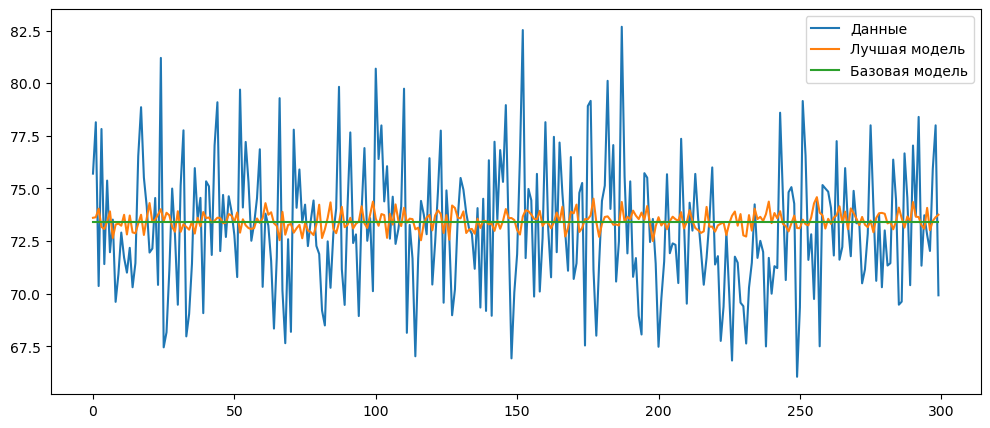

In [41]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test_upr.values, label='Данные')
ax.plot(y1_pred_best, label='Лучшая модель')
ax.plot(y1_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Видим, насколько не соответствует лучшая модель исходным данным.

In [42]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве

compare1 = get_metrics('Базовая модель', y_test_upr, y1_pred_base)
compare1 = compare1.append(get_metrics('Лучшая модель (Lasso)', y_test_upr, y1_pred_best))
compare1

R2  RMSE   MAE  max_error
Базовая модель        -0.01 -3.08 -2.48      -9.28
Лучшая модель (Lasso) -0.02 -3.11 -2.51      -8.86

## Часть 2. Модели для прогноза прочности при растяжении, МПа

In [43]:
X_pr = df.copy()
y_pr = X_pr.pop('Прочность при растяжении, МПа')
X_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1022
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1000 non-null   float64
 1   Плотность, кг/м3                      1000 non-null   float64
 2   модуль упругости, ГПа                 1000 non-null   float64
 3   Количество отвердителя, м.%           1000 non-null   float64
 4   Содержание эпоксидных групп,%_2       1000 non-null   float64
 5   Температура вспышки, С_2              1000 non-null   float64
 6   Поверхностная плотность, г/м2         1000 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1000 non-null   float64
 8   Потребление смолы, г/м2               1000 non-null   float64
 9   Угол нашивки, град                    1000 non-null   int32  
 10  Шаг нашивки                           1000 non-null   float64
 11  Плотность нашивки

In [44]:
#Разделим данные на обучающую и тестовую выборку

X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr, y_pr, test_size=0.3, random_state=42)

In [45]:
#Проверим разделение

print(X_train_pr.shape)
print(X_test_pr.shape)

(700, 12)
(300, 12)


#### Нормализуем значения

In [46]:
scaler = MinMaxScaler()
X_train_pr_norm = scaler.fit_transform(X_train_pr)
X_test_pr_norm = scaler.transform(X_test_pr)
X_train_pr_norm

array([[0.6880626 , 0.04276343, 0.44112821, ..., 1.        , 0.45711284,
        0.48622653],
       [0.27254128, 0.51555513, 0.51399785, ..., 0.        , 0.88703244,
        0.33014733],
       [0.489449  , 0.72212625, 0.67984038, ..., 0.        , 0.04948856,
        0.87639155],
       ...,
       [0.58696556, 0.42473537, 0.81961226, ..., 1.        , 0.45103716,
        0.61257161],
       [0.37439017, 0.43965487, 0.44845758, ..., 0.        , 0.38854483,
        0.57484482],
       [0.90465353, 0.43334053, 0.65070323, ..., 0.        , 0.73826198,
        0.76801487]])

Используя библиотеку lazy predict попробуем подобрать лучшую модель

In [47]:
reg = LazyRegressor(verbose=0,
                    ignore_warnings=False,
                    custom_metric=None)
models, predictions = reg.fit(X_train_pr_norm, X_test_pr_norm, y_train_pr, y_test_pr)
models

100%|██████████| 42/42 [00:10<00:00,  3.96it/s]


Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
SVR                                         -0.04       0.00  464.35   
QuantileRegressor                           -0.04      -0.00  464.42   
NuSVR                                       -0.04      -0.00  464.42   
DummyRegressor                              -0.04      -0.00  464.63   
LassoLars                                   -0.05      -0.01  465.84   
ElasticNetCV                                -0.05      -0.01  466.08   
BayesianRidge                               -0.05      -0.01  466.44   
GammaRegressor                              -0.05      -0.01  466.73   
TweedieRegressor                            -0.05      -0.01  466.77   
LarsCV                                      -0.05      -0.01  467.09   
LassoLarsCV                                 -0.05      -0.01  467.09   
LassoCV                                     -0.06      -0.01  467.68   
OrthogonalMatchingPursuit                   -0.06      -0.01  467.69   
LassoLarsIC                                 -0.06      -0.01  467.72   
ElasticNet                                  -0.06      -0.02  468.19   
OrthogonalMatchingPursuitCV                 -0.07      -0.03  470.65   
PassiveAggressiveRegressor                  -0.08      -0.03  472.06   
HuberRegressor                              -0.08      -0.03  472.12   
Lasso                                       -0.08      -0.04  472.49   
RidgeCV                                     -0.08      -0.04  472.97   
PoissonRegressor                            -0.08      -0.04  473.17   
Ridge                                       -0.08      -0.04  473.20   
Lars                                        -0.08      -0.04  473.23   
TransformedTargetRegressor                  -0.08      -0.04  473.23   
LinearRegression                            -0.08      -0.04  473.23   
SGDRegressor                                -0.08      -0.04  473.79   
RandomForestRegressor                       -0.11      -0.06  478.64   
AdaBoostRegressor                           -0.12      -0.08  482.37   
ExtraTreesRegressor                         -0.14      -0.09  485.05   
GradientBoostingRegressor                   -0.14      -0.10  486.84   
XGBRegressor                                -0.24      -0.19  507.01   
BaggingRegressor                            -0.26      -0.21  510.14   
HistGradientBoostingRegressor               -0.27      -0.22  512.64   
KNeighborsRegressor                         -0.27      -0.22  512.91   
LGBMRegressor                               -0.28      -0.23  514.91   
RANSACRegressor                             -1.25      -1.16  681.91   
ExtraTreeRegressor                          -1.44      -1.35  711.37   
DecisionTreeRegressor                       -1.47      -1.37  715.08   
GaussianProcessRegressor                   -14.08     -13.48 1767.01   
LinearSVR                                  -14.92     -14.28 1815.37   
MLPRegressor                               -24.15     -23.14 2281.79   
KernelRidge                                -29.28     -28.06 2503.57   

                               Time Taken  
Model                                      
SVR                                  0.08  
QuantileRegressor                    6.49  
NuSVR                                0.05  
DummyRegressor                       0.01  
LassoLars                            0.01  
ElasticNetCV                         0.07  
BayesianRidge                        0.01  
GammaRegressor                       0.01  
TweedieRegressor                     0.01  
LarsCV                               0.03  
LassoLarsCV                          0.03  
LassoCV                              0.09  
OrthogonalMatchingPursuit            0.01  
LassoLarsIC                          0.01  
ElasticNet                           0.01  
OrthogonalMatchingPursuitCV          0.01  
PassiveAggressiveRegressor           0.01  
HuberRegressor            

Ситуация все та же, базовая модель в топе

In [48]:
# различные модели с параметрами по умолчанию
models2_def = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)    
}

stat2_1 = run_models(models2_def, X_train_pr_norm, y_train_pr)
stat2_1.style.highlight_max(color='green', axis=0)

Модели все так же, как в задаче выше, плохо описывают данные.
R2 близок к 0 для линейных моделей и метода опорных векторов. Значит, они не лучше базовой модели. И остальные метрики у них примерно совпадают с базовой моделью.

Гораздо хуже линейных с гиперпараметрами по умолчанию отработали деревья решений.


In [49]:
s_models2 = {}

### Попробуем улучшить модели с помощью подбора гиперпараметров

##### Ridge

alpha, default=1.0
Regularization strength; must be a positive float

solver {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’}, default=’auto’
Solver to use in the computational routines

random_state - только для ‘sag’, ‘saga’

positive - только для ‘lbfgs’

In [50]:
params2 = [
  {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'alpha': range(10, 1000, 10)
  },
  {
    'solver': ['sag', 'saga'],
    'alpha': range(10, 1000, 10),
    'random_state': [42]
  },
  {
    'solver': ['lbfgs'],
    'alpha': range(10, 1000, 10),
    'positive': [True]
  }
]
search, smodel = run_grid_search(Ridge(), params2, X_train_pr_norm, y_train_pr)
s_models2[str(smodel)] = smodel
search[search['rank']<3]

params     MAE  rank
499   {'alpha': 30, 'random_state': 42, 'solver': 'sag'} -389.78     1
500  {'alpha': 30, 'random_state': 42, 'solver': 'saga'} -389.78     2

##### Lasso

alpha, default=1.0
Constant that multiplies the L1 term. 

In [51]:
params2 = [
  {
    'alpha': [0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100]
  }
]
search, smodel = run_grid_search(Lasso(), params2, X_train_pr_norm, y_train_pr)
s_models2[str(smodel)] = smodel
search[search['rank']<3]

params     MAE  rank
1  {'alpha': 1} -390.66     2
2  {'alpha': 5} -389.78     1

##### SVR

kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}

Остальные параметры подходят для разных ядер

C, default=1.0
Regularization parameter

In [52]:
params2 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.02]
    },
    {
      'kernel': ['rbf'],
      'gamma': ['scale', 'auto'],
      'C': [0.01, 0.05, 0.1, 0.2, 0.3]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.001, 0.01, 0.1]
    }
]

search, smodel = run_grid_search(SVR(), params2, X_train_pr_norm, y_train_pr)
s_models2[str(smodel)] = smodel
search[search['rank']<3]

params     MAE  rank
4  {'C': 0.01, 'kernel': 'poly'} -390.37     2
5  {'C': 0.02, 'kernel': 'poly'} -390.15     1

##### DecisionTreeRegressor

criterion {“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}
The function to measure the quality of a split.

splitter{“best”, “random”}

max_depth
The maximum depth of the tree

max_features
The number of features to consider when looking for the best split

In [53]:
params2 = {
    'random_state': [42],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 3],
    'max_features': range(1, 11, 1)
}
search, smodel = run_grid_search(DecisionTreeRegressor(), params2, X_train_pr_norm, y_train_pr)
s_models2[str(smodel)] = smodel
search[search['rank']<3]

params  \
120    {'criterion': 'absolute_error', 'max_depth': 1, 'max_features': 1, 'random_state': 42, 'splitter': 'best'}   
122    {'criterion': 'absolute_error', 'max_depth': 1, 'max_features': 2, 'random_state': 42, 'splitter': 'best'}   
161  {'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 1, 'random_state': 42, 'splitter': 'random'}   

        MAE  rank  
120 -390.47     2  
122 -390.47     2  
161 -390.36     1

##### GradientBoostingRegressor

n_estimators
The number of boosting stages to perform

loss {‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}
Loss function to be optimized

criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}
The function to measure the quality of a split

max_depth
The maximum depth of the tree

max_features
The number of features to consider when looking for the best split

In [54]:
params2 = {
    'random_state': [42],
    'loss': ['squared_error', 'absolute_error'], 
    #'criterion': ['friedman_mse', 'squared_error'],
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 3],
    'max_features': [1, 2, 5, 11]    
}
search, smodel = run_grid_search(GradientBoostingRegressor(), params2, X_train_pr_norm, y_train_pr)
s_models2[str(smodel)] = smodel
search[search['rank']<3]

params  \
12   {'loss': 'squared_error', 'max_depth': 2, 'max_features': 1, 'n_estimators': 50, 'random_state': 42}   
13  {'loss': 'squared_error', 'max_depth': 2, 'max_features': 1, 'n_estimators': 100, 'random_state': 42}   

       MAE  rank  
12 -387.25     1  
13 -388.02     2

##### Сравним модели, выберем лучшую

In [55]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat2_2 = run_models(s_models2, X_train_pr_norm, y_train_pr)
stat2_2.style.highlight_max(color='green', axis=0)

Результаты аналогичны полученным в предыдущем подразделе, за исключением того, что здесь есть GradientBoosting. После подбора параметров он оказался лучше остальных моделей. Но по-прежнему крайне плохо описывает исходные данные.
Линейные после подбора немного улучшили характеристики.

Метод опорных векторов отработал аналогично линейным моделям.

Лучший результат дает градиентный бустинг. Значения ошибок примерно такие же, как у дерева решений. Но коэффициент детерминации выше, положительный, что показывает чуть лучшую объясняющую способность модели.

In [56]:
# Предсказание базовой модели

base_model2 = DummyRegressor(strategy='mean')
base_model2.fit(X_train_pr_norm, y_train_pr)
y2_pred_base = base_model2.predict(X_test_pr_norm)

In [57]:
# Предсказание лучшей модели

best_model2 = GradientBoostingRegressor(max_depth=2, max_features=1, n_estimators=50, random_state=42)
best_model2.fit(X_train_pr_norm, y_train_pr)
y2_pred_best = best_model2.predict(X_test_pr_norm)

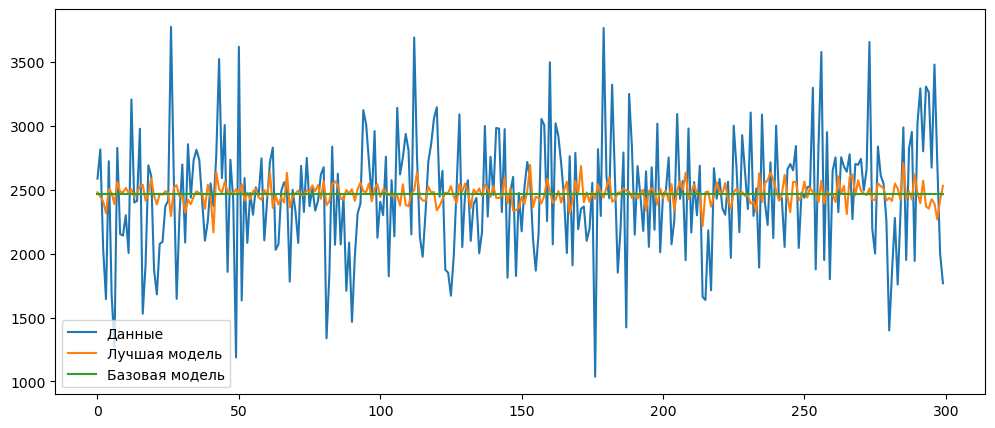

In [58]:
# Визуализация

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_test_pr.values, label='Данные')
ax.plot(y2_pred_best, label='Лучшая модель')
ax.plot(y2_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Визуализируя результаты градиентного бустинга с выбранными параметрами, мы видим насколько они далеки от исходных данных. 

In [59]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare2 = get_metrics('Базовая модель', y_test_pr, y2_pred_base)
compare2 = compare2.append(get_metrics('Лучшая модель (градиентный бустинг)', y_test_pr, y2_pred_best))
compare2

R2    RMSE     MAE  max_error
Базовая модель                      -0.00 -464.63 -363.89   -1432.25
Лучшая модель (градиентный бустинг) -0.01 -467.12 -366.43   -1479.88